In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !cp "drive/MyDrive/Question Generation/vae/models.py" .
%cd '/content/drive/MyDrive/Second/MCQ/vae/'
!pwd

/content/drive/MyDrive/Second/MCQ/vae
/content/drive/MyDrive/Second/MCQ/vae


In [3]:
filename = "train"

In [4]:
!nvcc --version

import torch
print("\nPytorch version: ", torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0

Pytorch version:  2.0.0+cu118


In [5]:
!pip install -q transformers
!pip install -q json-lines
## scatter 1.12+cu113
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
# scatter 1.13+cu116
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q import-ipynb
# import import_ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.3 MB/s eta 0:00:00


In [6]:
import argparse
import pickle
import collections

from copy import deepcopy
import torch
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import os
from d3_files.models2 import DiscreteVAE
from d3_files.squad_utils import (InputFeatures, convert_examples_to_harv_features,
                         read_examples, read_squad_examples,_improve_answer_span,_check_is_max_context)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [8]:
def convert_examples_to_features_answer_id(examples, tokenizer, max_seq_length,
                                           doc_stride, max_query_length, max_distractor_length,max_ans_length, is_training):
    """Loads a data file into a list of `InputBatch`s.
       In addition to the original InputFeature class, it contains 
       c_ids: ids for context
       tag ids: indicate the answer span of context,
       noq_start_position: start position of answer in context without concatenation of question
       noq_end_position: end position of answer in context without concatenation of question
    """


    features = []
    for (example_index, example) in tqdm(enumerate(examples), total=len(examples)):
        qa_id = example.qas_id
        query_tokens = tokenizer.tokenize(example.question_text)
        distractor_tokens1 = tokenizer.tokenize(example.distractor_texts[0])
        distractor_tokens2 = tokenizer.tokenize(example.distractor_texts[1])
        distractor_tokens3 = tokenizer.tokenize(example.distractor_texts[2])

        if len(query_tokens) > max_query_length:
            query_tokens = query_tokens[0:max_query_length]
        if len(distractor_tokens1) > max_distractor_length:
            distractor_tokens1 = distractor_tokens1[0:max_distractor_length]
        if len(distractor_tokens2) > max_distractor_length:
            distractor_tokens2 = distractor_tokens2[0:max_distractor_length]
        if len(distractor_tokens3) > max_distractor_length:
            distractor_tokens3 = distractor_tokens3[0:max_distractor_length]

        tok_to_orig_index = []
        orig_to_tok_index = []
        all_doc_tokens = []
        for (i, token) in enumerate(example.doc_tokens):
            orig_to_tok_index.append(len(all_doc_tokens))
            sub_tokens = tokenizer.tokenize(token)
            for sub_token in sub_tokens:
                tok_to_orig_index.append(i)
                all_doc_tokens.append(sub_token)

        tok_start_position = None
        tok_end_position = None
        if is_training and example.is_impossible:
            tok_start_position = -1
            tok_end_position = -1
        if is_training and not example.is_impossible:
            tok_start_position = orig_to_tok_index[example.start_position]
            if example.end_position < len(example.doc_tokens) - 1:
                tok_end_position = orig_to_tok_index[example.end_position + 1] - 1
            else:
                tok_end_position = len(all_doc_tokens) - 1
            (tok_start_position, tok_end_position) = _improve_answer_span(
                all_doc_tokens, tok_start_position, tok_end_position, tokenizer,
                example.orig_answer_text)

        # The -6 accounts for [CLS], Q:[SEP], (D1:[SEP], D1:[SEP], D1:[SEP]), and C:[SEP]
        max_tokens_for_doc = max_seq_length - len(query_tokens)-len(distractor_tokens1)-len(distractor_tokens2)-len(distractor_tokens3) - 6

        # We can have documents that are longer than the maximum sequence length.
        # To deal with this we do a sliding window approach, where we take chunks
        # of the up to our max length with a stride of `doc_stride`.
        _DocSpan = collections.namedtuple(  # pylint: disable=invalid-name
            "DocSpan", ["start", "length"])
        doc_spans = []
        start_offset = 0
        while start_offset < len(all_doc_tokens):
            length = len(all_doc_tokens) - start_offset
            if length > max_tokens_for_doc:
                length = max_tokens_for_doc
            doc_spans.append(_DocSpan(start=start_offset, length=length))
            if start_offset + length == len(all_doc_tokens):
                break
            start_offset += min(length, doc_stride)

        for (doc_span_index, doc_span) in enumerate(doc_spans):
            tokens = []
            token_to_orig_map = {}
            token_is_max_context = {}
            segment_ids = []
            tokens.append("[CLS]")
            segment_ids.append(0)
            for token in query_tokens:
                tokens.append(token)
                segment_ids.append(0)
            tokens.append("[SEP]")
            segment_ids.append(0)
            ## make change here: bert potentially does not like multiple sep
            for token in distractor_tokens1:
                tokens.append(token)
                segment_ids.append(0)
            tokens.append("[SEP]")
            segment_ids.append(0)
            for token in distractor_tokens2:
                tokens.append(token)
                segment_ids.append(0)
            tokens.append("[SEP]")
            segment_ids.append(0)
            for token in distractor_tokens3:
                tokens.append(token)
                segment_ids.append(0)
            tokens.append("[SEP]")
            segment_ids.append(0)

            context_tokens = list()
            context_tokens.append("[CLS]")
            for i in range(doc_span.length):
                split_token_index = doc_span.start + i
                token_to_orig_map[len(
                    tokens)] = tok_to_orig_index[split_token_index]

                is_max_context = _check_is_max_context(doc_spans, doc_span_index,
                                                       split_token_index)
                token_is_max_context[len(tokens)] = is_max_context
                tokens.append(all_doc_tokens[split_token_index])
                segment_ids.append(1)
                context_tokens.append(all_doc_tokens[split_token_index])
            tokens.append("[SEP]")
            segment_ids.append(1)
            context_tokens.append("[SEP]")

            input_ids = tokenizer.convert_tokens_to_ids(tokens)

            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1] * len(input_ids)

            # Zero-pad up to the sequence length.
            while len(input_ids) < max_seq_length:
                input_ids.append(0)
                input_mask.append(0)
                segment_ids.append(0)

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length

            start_position = None
            end_position = None
            noq_start_position = None
            noq_end_position = None

            if is_training and not example.is_impossible:
                # For training, if our document chunk does not contain an annotation
                # we throw it out, since there is nothing to predict.
                doc_start = doc_span.start
                doc_end = doc_span.start + doc_span.length - 1
                out_of_span = False
                if not (tok_start_position >= doc_start and
                        tok_end_position <= doc_end):
                    out_of_span = True
                if out_of_span:
                    start_position = 0
                    end_position = 0
                    noq_start_position = 0
                    noq_end_position = 0
                else:
                    ## second change if previous made
                    doc_offset = len(query_tokens) + 2 + (len(distractor_tokens1) + 1)+(len(distractor_tokens2) + 1)+(len(distractor_tokens3) + 1)
                    start_position = tok_start_position - doc_start + doc_offset
                    end_position = tok_end_position - doc_start + doc_offset

                    # plus one for [CLS] token
                    noq_start_position = tok_start_position - doc_start + 1
                    noq_end_position = tok_end_position - doc_start + 1

                # skip the context that does not contain any answer span
                if out_of_span:
                    continue

            if is_training and example.is_impossible:
                start_position = 0
                end_position = 0
                noq_start_position = 0
                noq_end_position = 0
            q_tokens = deepcopy(query_tokens)[:max_query_length - 2]
            q_tokens.insert(0, "[CLS]")
            q_tokens.append("[SEP]")
            q_ids = tokenizer.convert_tokens_to_ids(q_tokens)
            d_tokens1 = deepcopy(distractor_tokens1)[:max_distractor_length - 2]
            d_tokens2 = deepcopy(distractor_tokens2)[:max_distractor_length - 2]
            d_tokens3 = deepcopy(distractor_tokens3)[:max_distractor_length - 2]
            d_tokens1.insert(0, "[CLS]")
            d_tokens2.insert(0, "[CLS]")
            d_tokens3.insert(0, "[CLS]")
            ## Above line was there in first training, and we subtracted off 2 instead of 1, now getting rid of it and only subtracting 1.
            d_tokens1.append("[SEP]")
            d_tokens2.append("[SEP]")
            d_tokens3.append("[SEP]")
            d_ids1 = tokenizer.convert_tokens_to_ids(d_tokens1)
            d_ids2 = tokenizer.convert_tokens_to_ids(d_tokens2)
            d_ids3 = tokenizer.convert_tokens_to_ids(d_tokens3)
            c_ids = tokenizer.convert_tokens_to_ids(context_tokens)

            # pad up to maximum length
            while len(q_ids) < max_query_length:
                q_ids.append(0)
                
            while len(d_ids1) < max_distractor_length:
                d_ids1.append(0)
            while len(d_ids2) < max_distractor_length:
                d_ids2.append(0)
            while len(d_ids3) < max_distractor_length:
                d_ids3.append(0)

            while len(c_ids) < max_seq_length:
                c_ids.append(0)

            # answer_text = example.orig_answer_text

            # answer_tokens = tokenizer.tokenize(answer_text)[:max_ans_length - 2]
            # answer_tokens.insert(0, "[CLS]")
            # answer_tokens.append("[SEP]")
            # answer_ids = tokenizer.convert_tokens_to_ids(answer_tokens)

            # while len(answer_ids) < max_ans_length:
            #     answer_ids.append(0)

            context_segment_ids = [0] * len(c_ids)
            for answer_idx in range(noq_start_position, noq_end_position + 1):
                context_segment_ids[answer_idx] = 1
            # BIO tagging scheme
            tag_ids = [0] * len(c_ids)  # Outside
            if noq_start_position is not None and noq_end_position is not None:
                tag_ids[noq_start_position] = 1  # Begin
                # Inside tag
                for idx in range(noq_start_position + 1, noq_end_position + 1):
                    tag_ids[idx] = 2

            assert len(tag_ids) == len(c_ids), "length of tag :{}, length of c :{}".format(
                len(tag_ids), len(c_ids))
            features.append(
                InputFeatures(
                    unique_id=qa_id,
                    example_index=example_index,
                    doc_span_index=doc_span_index,
                    tokens=tokens,
                    token_to_orig_map=token_to_orig_map,
                    token_is_max_context=token_is_max_context,
                    input_ids=input_ids,
                    input_mask=input_mask,
                    c_ids=c_ids,
                    context_tokens=context_tokens,
                    q_ids=q_ids,
                    q_tokens=q_tokens,
                    d1_ids=d_ids1,
                    d1_tokens=d_tokens1,
                    d2_ids=d_ids2,
                    d2_tokens=d_tokens2,
                    d3_ids=d_ids3,
                    d3_tokens=d_tokens3,
                    answer_text=example.orig_answer_text,
                    tag_ids=tag_ids,
                    segment_ids=segment_ids,
                    context_segment_ids=context_segment_ids,
                    noq_start_position=noq_start_position,
                    noq_end_position=noq_end_position,
                    start_position=start_position,
                    end_position=end_position,
                    is_impossible=example.is_impossible))

    return features



In [9]:
def loadDataset(args):  
    tokenizer = BertTokenizer.from_pretrained(args.bert_model)
    args.tokenizer = tokenizer

    device = torch.cuda.current_device()
    checkpoint = torch.load(args.checkpoint, map_location="cpu")
    vae = DiscreteVAE(checkpoint["args"])
    vae.load_state_dict(checkpoint["state_dict"])
    vae.eval()
    vae = vae.to(device)
    
    examples = read_squad_examples(args.data_file, is_training=True, debug=False)
    features = convert_examples_to_features_answer_id(examples,
                                                      tokenizer=tokenizer,
                                                      max_seq_length=args.max_c_len,
                                                      max_query_length=args.max_q_len,
                                                      max_distractor_length=args.max_d_len,
                                                      max_ans_length=args.max_q_len,
                                                      doc_stride=128,
                                                      is_training=True)
    # indices = np.sort(np.random.choice(np.arange(len(features)), min(len(features),args.maxParaCount), replace=False))
    
    all_index_ids = torch.tensor([int(f.unique_id) for f in features], dtype=torch.long)
    
    all_c_ids = torch.tensor([f.c_ids for f in features], dtype=torch.long)
    all_q_ids = torch.tensor([f.q_ids for f in features], dtype=torch.long)
    all_tag_ids = torch.tensor([f.tag_ids for f in features], dtype=torch.long)
    all_a_ids = (all_tag_ids != 0).long()

    data = TensorDataset(all_index_ids, all_c_ids, all_q_ids, all_a_ids)
    data_loader = DataLoader(data, shuffle=False, batch_size=args.batch_size)

    return data_loader, tokenizer, vae
def main(args,data_loader, tokenizer, vae):
    new_features = []
    generatedDistractors = dict()
    generatedMCQs = dict()

    for batch in tqdm(data_loader, total=len(data_loader)):
        qa_index = batch[0]
        c_ids = batch[1].to(device)
        true_q_ids = batch[2].to(device)
        true_a_ids = batch[3].to(device)
        
        
        with torch.no_grad():
            _, _, zq, _, za, _, _, zd1, zd2, zd3 = vae.prior_encoder(c_ids)
            batch_d1_ids, batch_d2_ids, batch_d3_ids = vae.generateDistractors(zq, za, c_ids, zd1, zd2, zd3, true_a_ids, true_q_ids)

        for i in range(c_ids.size(0)):
            d1_ids = batch_d1_ids[i].cpu().tolist()
            d2_ids = batch_d2_ids[i].cpu().tolist()
            d3_ids = batch_d3_ids[i].cpu().tolist()

            d1_text = tokenizer.decode(d1_ids, skip_special_tokens=True)
            d2_text = tokenizer.decode(d2_ids, skip_special_tokens=True)
            d3_text = tokenizer.decode(d3_ids, skip_special_tokens=True)
            
            if qa_index[i].item() not in generatedDistractors: 
                generatedDistractors[qa_index[i].item()] = [d1_text, d2_text, d3_text]
        # sample latent variable K times
        for _ in range(args.k):
          with torch.no_grad():
              _, _, zq, _, za, _, _, zd1, zd2, zd3 = vae.prior_encoder(c_ids)
              batch_q_ids, batch_start_positions, batch_end_positions, batch_d1_ids, batch_d2_ids, batch_d3_ids = vae.generate(zq, za, c_ids, zd1, zd2, zd3)

          for i in range(c_ids.size(0)):
              _c_ids = c_ids[i].cpu().tolist()
              q_ids = batch_q_ids[i].cpu().tolist()
              start_pos_a = batch_start_positions[i].item()
              end_pos_a = batch_end_positions[i].item()
              d1_ids = batch_d1_ids[i].cpu().tolist()
              d2_ids = batch_d2_ids[i].cpu().tolist()
              d3_ids = batch_d3_ids[i].cpu().tolist()
              
              a_ids = _c_ids[start_pos_a: end_pos_a+1]
              # c_text = tokenizer.decode(_c_ids, skip_special_tokens=True)
              q_text = tokenizer.decode(q_ids, skip_special_tokens=True)
              a_text = tokenizer.decode(a_ids, skip_special_tokens=True)
              d1_ids = batch_d1_ids[i].cpu().tolist()
              d2_ids = batch_d2_ids[i].cpu().tolist()
              d3_ids = batch_d3_ids[i].cpu().tolist()

              d1_text = tokenizer.decode(d1_ids, skip_special_tokens=True)
              d2_text = tokenizer.decode(d2_ids, skip_special_tokens=True)
              d3_text = tokenizer.decode(d3_ids, skip_special_tokens=True)
              
              if qa_index[i].item() not in generatedMCQs: 
                  generatedMCQs[qa_index[i].item()] = []
              generatedMCQs[qa_index[i].item()].append(dict())
              generatedMCQs[qa_index[i].item()][-1]['gen_question'] = q_text
              generatedMCQs[qa_index[i].item()][-1]['gen_answer'] = a_text                  
              generatedMCQs[qa_index[i].item()][-1]['gen_distractors'] = [d1_text, d2_text, d3_text]

    return generatedDistractors, generatedMCQs

In [10]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def setArguments(dataFile, maxParaCount=float("inf"), seed=1004, bert_model="bert-base-uncased", max_length=384, batch_size=64, ratio=1, k = 1):
    args = dict()
    args['maxParaCount'] = maxParaCount
    args['seed'] = seed
    args['bert_model'] = bert_model
    args['max_length'] = max_length
    args['batch_size'] = batch_size
    args['data_file'] = dataFile
    args['checkpoint'] = "../save/vae-checkpoint/3d/best_f1_model.pt"
    args['output_dir'] = "../data/synthetic_data/"
    args['ratio'] = ratio
    args['k'] = k
    args['max_c_len']=384
    args['max_q_len']=64
    args['max_d_len']=5
    args['squad'] = True
    
    return dotdict(args)    

In [11]:
k = 3
args = setArguments(dataFile=f'../data/sciq/squad_format/{filename}.json',k=k)
data_loader, tokenizer, vae = loadDataset(args)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_

In [ ]:
generatedDistractors, generatedMCQs = main(args,data_loader, tokenizer, vae)

100%|██████████| 152/152 [1:17:54<00:00, 30.76s/it]


In [ ]:
!pwd

/content/drive/MyDrive/Second/MCQ/vae


In [ ]:
!ls '../../../Question Generation/data/squad/objective_output/MCQ Gen/MCQ_HCVAE'

sciq_mcqhcvae_metrics.pickle  sciq_test_generated_with_baseline.json
sciq_test_generated.json


In [ ]:
import json
with open(f'../data/sciq/squad_format/{filename}.json') as f:
  data = json.load(f)

for topic in data['data']:
  for paragraph in topic['paragraphs']:
      qa = paragraph['qas'][0]
      qa_id = qa['id']
      qa['generated_distractors'] = generatedDistractors[int(qa_id)]
      for mcq in generatedMCQs[int(qa_id)]:
          paragraph['qas'].append(dict())
          paragraph['qas'][-1]['generated_question'] = mcq['gen_question']
          paragraph['qas'][-1]['generated_answer'] = mcq['gen_answer']
          paragraph['qas'][-1]['generated_distractors'] = mcq['gen_distractors']
          paragraph['qas'][-1]['generated_mcq'] = True
with open(f'../../../Question Generation/data/squad/objective_output/MCQ Gen/MCQ_HCVAE/sciq_{filename}_generated.json','w') as f:
  json.dump(data, f, ensure_ascii=False)


# Baselines

In [ ]:
!pip install -q transformers

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("voidful/bart-distractor-generation-pm")
model = AutoModelForSeq2SeqLM.from_pretrained("voidful/bart-distractor-generation-pm").to(device)

In [ ]:
import json
from tqdm.notebook import tqdm

In [ ]:
with open(f'../../../Question Generation/data/squad/objective_output/MCQ Gen/MCQ_HCVAE/sciq_{filename}_generated.json') as f:
  data = json.load(f)

for topic in data['data']:
  for paragraph in tqdm(topic['paragraphs']):
    for qa in paragraph['qas']:
      context = paragraph['context']
      if 'generated_mcq' in qa:
          question = qa['generated_question']
          answer = qa['generated_answer']
      else:
          question = qa['question']
          answer = qa['answers'][0]['text']
          
      model_input = " </s> ".join([context,question,answer])
      d_id_list = model.generate(tokenizer.encode(model_input,return_tensors='pt').to(device),num_return_sequences=3,num_beams=3)
      qa['baseline_distractors'] = tokenizer.batch_decode(d_id_list, skip_special_tokens=True)

with open(f'../../../Question Generation/data/squad/objective_output/MCQ Gen/MCQ_HCVAE/sciq_{filename}_generated_with_baseline.json', 'w') as f:
  json.dump(data, f, ensure_ascii=False)

  0%|          | 0/9574 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


# Evaluation

In [12]:
!pip install -q transformers
!pip install -q json-lines
!pip install -q textstat
!pip install -q transformers sentencepiece 
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import BertModel, BertTokenizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
torch.manual_seed(1)
import numpy as np
from torch.utils.data import Dataset, DataLoader
import textstat
!pip install -q -U sentence-transformers
from sentence_transformers import SentenceTransformer,util
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [13]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

In [14]:
import re

In [15]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-50")
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def preprocess(passage):
    # https://stackoverflow.com/questions/1276764/
    preprocess_pipeline = passage.lower()
    preprocess_pipeline = re.sub(r'[^a-zA-Z0-9]', ' ', preprocess_pipeline)
    preprocess_pipeline = preprocess_pipeline.split()
    preprocess_pipeline = [wordnet_lemmatizer.lemmatize(token) for token in preprocess_pipeline]
    return preprocess_pipeline

[==================================================] 100.0% 66.0/66.0MB downloaded


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [16]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout,embedding, bidirectional=True):
        super(CustomLSTM, self).__init__()
        self.embedding = embedding
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)
        if dropout > 0.0 and num_layers == 1:
            dropout = 0.0

        self.context_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, dropout=dropout,
                            bidirectional=bidirectional, batch_first=True)
        
        self.fc = nn.Linear(2 * hidden_size, 1)
    def forward(self, c_ids,token_type_ids):
        context_embeddings = c_ids
        lstm_out, (hidden_context,cell) = self.context_lstm(context_embeddings)
        lstm_out = self.dropout(lstm_out)

        hidden = self.dropout(torch.cat((hidden_context[-2,:,:], hidden_context[-1,:,:]), dim = 1))
        y  = self.fc(hidden)
        log_probs = torch.sigmoid(y)
        return log_probs.flatten()

In [17]:
class DistractorDB(Dataset):    
    def __init__(self, data, tokenizer,args):
        super().__init__()
        self.tokenizer = tokenizer
        self.max_c_len = args.max_c_len
        self.max_d_len = args.max_d_len
        self.max_comb_len = args.max_d_len + args.max_d_len+3
        
        self.all_answers = []
        self.all_distractors = []
        self.context_lengths = []
        self.context_readability = []
        self.generated_mcq = args.generated_mcq
        self.evaluate_baseline = args.evaluate_baseline

        for topic in data['data']:
          for paragraph in topic['paragraphs']:
              context = paragraph['context']
              context_readability = textstat.smog_index(context)
              if self.generated_mcq:
                qa_list = paragraph['qas'][1:]
                answer_list = [qa['generated_answer'] for qa in qa_list]
              else:
                qa_list = [paragraph['qas'][0]]
                answer_list = [qa_list[0]['answers'][0]['text']]
              for i, qa in enumerate(qa_list):
                  answer = answer_list[i]
                  if self.evaluate_baseline:
                      distractors = qa['baseline_distractors']
                  else:
                      distractors = qa['generated_distractors']

                  a_ids = np.zeros((50,))
                  answer_tokens = preprocess(answer)
                  for token in answer_tokens:
                    if token in word_vectors:
                      a_ids += word_vectors[token]

                  d_list = []
                  for distractor in distractors:
                    d_ids = np.zeros((50,))
                    distractor_tokens = preprocess(distractor)
                    for token in distractor_tokens:
                      if token in word_vectors:
                        d_ids += word_vectors[token]
                    # d_list.append(d_ids)
                    self.all_answers.append(a_ids)
                    self.all_distractors.append(d_ids)     
                    self.context_lengths.append(len(context))
                    self.context_readability.append(context_readability)
        # assert len(self.all_answers) == len(self.all_distractors)
        # assert len(self.all_answers) == len(self.all_distractors)

                
    def __len__(self):
      return len(self.all_answers)

    def __getitem__(self, index):
      combined_ids = torch.cat([torch.from_numpy(self.all_answers[index]).float(),torch.from_numpy(self.all_distractors[index]).float()]).float()

      return combined_ids, self.context_lengths[index], self.context_readability[index]

In [18]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def setArguments(myData=[], maxParaCount=float("inf"), seed=1004, bert_model="bert-base-uncased", max_length=384, batch_size=64, ratio=1, k = 1):
    args = dict()
    args['maxParaCount'] = maxParaCount
    args['seed'] = seed
    args['myData'] = myData
    args['bert_model'] = bert_model
    args['max_length'] = max_length
    args['batch_size'] = batch_size
    args['output_dir'] = "../data/synthetic_data/"
    args['ratio'] = ratio
    args['k'] = k
    args['max_c_len']=384
    args['max_q_len']=64
    args['max_d_len']=15
    args['squad'] = True
    
    return dotdict(args)    
args = setArguments()

In [19]:
class Embedding(nn.Module):
    def __init__(self, bert_model):
        super(Embedding, self).__init__()
        bert_embeddings = BertModel.from_pretrained(bert_model).embeddings
        self.word_embeddings = bert_embeddings.word_embeddings
        self.token_type_embeddings = bert_embeddings.token_type_embeddings
        self.position_embeddings = bert_embeddings.position_embeddings
        self.LayerNorm = bert_embeddings.LayerNorm
        self.dropout = bert_embeddings.dropout

    def forward(self, input_ids, token_type_ids=None, position_ids=None):
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        if position_ids is None:
            seq_length = input_ids.size(1)
            position_ids = torch.arange(
                seq_length, dtype=torch.long, device=input_ids.device)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        position_embeddings = self.position_embeddings(position_ids)

        embeddings = words_embeddings + token_type_embeddings + position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        
        return embeddings

In [20]:
embedding = Embedding('bert-base-uncased')
model = CustomLSTM(input_size=100,
                  hidden_size=100, 
                  num_layers=1,
                  dropout=0.5,
                  bidirectional=True,embedding=embedding).to(device)
model.load_state_dict(torch.load("../../../Second/MCQ/discriminator_model/discriminator12.pth"))
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CustomLSTM(
  (embedding): Embedding(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (token_type_embeddings): Embedding(2, 768)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (context_lstm): LSTM(100, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

In [21]:
def getBERT_score(data):
  baseline_bert_scores = []
  mcqHCVAE_bert_scores = []
  for topic in data['data']:
    for paragraph in topic['paragraphs']:
      qa = paragraph['qas'][0]
      gt_distractor_embeddings = bert_model.encode(qa['distractors'])
      model_distractor_embeddings = bert_model.encode(qa['generated_distractors'])
      baseline_distractor_embeddings = bert_model.encode(qa['baseline_distractors'])
      model_gt_sim = util.cos_sim(model_distractor_embeddings,gt_distractor_embeddings)
      baseline_gt_sim = util.cos_sim(baseline_distractor_embeddings,gt_distractor_embeddings)
      mcqHCVAE_bert_scores.append(torch.mean(model_gt_sim))
      baseline_bert_scores.append(torch.mean(baseline_gt_sim))
  return mcqHCVAE_bert_scores, baseline_bert_scores

In [22]:
def evaluateDistractors(dataloader, model):
  running_score = 0
  metrics = torch.empty((0, 3), dtype=torch.float32)
  for (context_ids, lengths, readability_list) in dataloader:
    with torch.no_grad():
      context_ids = context_ids.to(device)            
      predictions = model(context_ids.unsqueeze(1),None)
      metrics = torch.cat((metrics, torch.stack([predictions.cpu(), lengths, readability_list], dim=1)), dim=0)
      condition = predictions < 0.5
      predictions[condition] = 0
      predictions[~condition] = 1
      running_score += predictions.sum()
  accuracy = running_score / len(dataloader.dataset)
  return metrics, accuracy
  

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Train set

In [35]:
with open(f'../../../Question Generation/data/squad/objective_output/MCQ Gen/MCQ_HCVAE/sciq_train_generated_with_baseline.json') as f:
  data = json.load(f)

In [37]:
metric_dict = dict()
mcqHCVAE_bert_scores, baseline_bert_scores = getBERT_score(data)
print(f"BERT similarity between MCQ_HCVAE distractors and ground truth distractors: {np.mean(mcqHCVAE_bert_scores):0.4f}")
print(f"BERT similarity between baseline distractors and ground truth distractors: {np.mean(baseline_bert_scores):0.4f}")

BERT similarity between MCQ_HCVAE distractors and ground truth distractors: 0.4148
BERT similarity between baseline distractors and ground truth distractors: 0.2968


In [38]:
print("Now using the Distractor Discriminator to evaluate distractors:")
for generated_mcq in [False, True]:
    if not generated_mcq:
        print("\tWhen distractors are generated given ground truth question, answer and context:")            
    else:
        print("\tWhen the full MCQ is generated given only the context:")
    for evaluate_baseline in [False, True]:
        args.generated_mcq = generated_mcq
        args.evaluate_baseline = evaluate_baseline
        dataset = DistractorDB(data, tokenizer, args)
        dataloader = DataLoader(dataset,batch_size=64,shuffle=False,num_workers=1)
        metrics, accuracy = evaluateDistractors(dataloader, model)
        metric_dict[(generated_mcq, evaluate_baseline)] = metrics
        if evaluate_baseline:
          print(f"\t\tThe accuracy for baseline distractors: {accuracy:0.4f}")
        else:
          print(f"\t\tThe accuracy for MCQ_HCVAE distractors: {accuracy:0.4f}")

Now using the Distractor Discriminator to evaluate distractors:
	When distractors are generated given ground truth question, answer and context:
		The accuracy for MCQ_HCVAE distractors: 0.6625
		The accuracy for baseline distractors: 0.5257
	When the full MCQ is generated given only the context:
		The accuracy for MCQ_HCVAE distractors: 0.5741
		The accuracy for baseline distractors: 0.5088


In [ ]:
import pickle
with open('../../../Question Generation/data/squad/objective_output/MCQ Gen/MCQ_HCVAE/sciq_mcqhcvae_metrics.pickle', 'wb') as h:
    pickle.dump(metric_dict, h)

In [39]:
from transformers import pipeline
question_answering = pipeline("question-answering",device= torch.cuda.current_device(),model="deepset/roberta-base-squad2")

In [40]:
from tqdm.notebook import tqdm

In [ ]:
data['#ata']

In [41]:
running_sum = 0
total = 0
for topic in data['data']:
  for paragraph in tqdm(topic['paragraphs']):
    context = paragraph['context']
    for qa in paragraph['qas']:
        gen_prefix = "generated_" if 'generated_mcq' in qa else ""
        if 'generated_mcq' in qa:
          answers = [qa['generated_answer']]
        else:
          answers = [ansInfo['text'] for ansInfo in qa['answers']]
        result = question_answering(question=qa[f'{gen_prefix}question'], context=context)
        
        if not 'generated_mcq' in qa:
          if result['answer'] in answers:
              running_sum += 1
          total+=1
print(f"Percentage of valid QA-pair: {100*running_sum/total:0.3f}%")

  0%|          | 0/9574 [00:00<?, ?it/s]

Percentage of valid QA-pair: 73.888%


In [ ]:
import pickle
with open(f'../../../Question Generation/data/squad/objective_output/MCQ Gen/MCQ_HCVAE/sciq_mcqhcvae_metrics.pickle','rb') as f:
  metric_dict = pickle.load(f)

In [ ]:
metric_info = metric_dict[False,False]

In [ ]:
metric_info.shape

torch.Size([2460, 3])

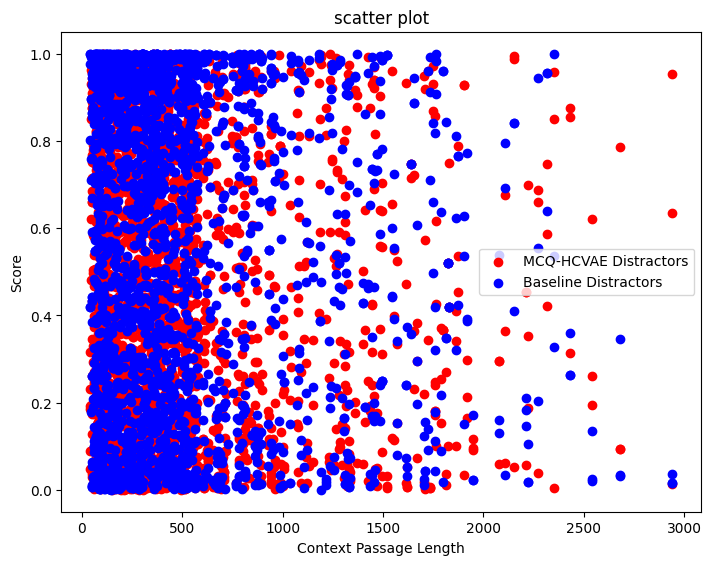

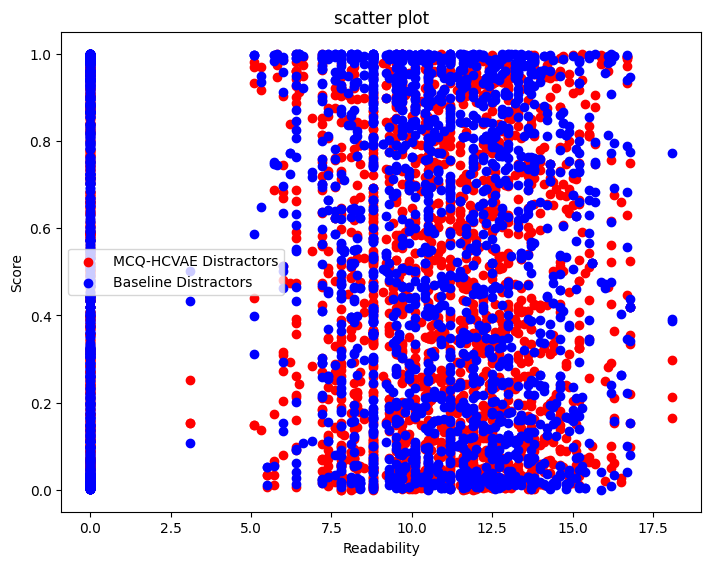

In [ ]:
import matplotlib.pyplot as plt

model_predictions = metric_dict[False,False][:,0]
baseline_predictions = metric_dict[False, True][:,0]
lengths = predictions = metric_dict[False,False][:,1]
readability_list = metric_dict[False,False][:,2]
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(lengths, model_predictions, color='r', label='MCQ-HCVAE Distractors')
ax.scatter(lengths, baseline_predictions, color='b', label='Baseline Distractors')
ax.legend()
ax.set_xlabel('Context Passage Length')
ax.set_ylabel('Score')
ax.set_title('scatter plot')
plt.show()

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(readability_list, model_predictions, color='r', label='MCQ-HCVAE Distractors')
ax.scatter(readability_list, baseline_predictions, color='b', label='Baseline Distractors')
ax.legend()
ax.set_xlabel('Readability')
ax.set_ylabel('Score')
ax.set_title('scatter plot')
plt.show()

## Test set

In [26]:
with open(f'../../../Question Generation/data/squad/objective_output/MCQ Gen/MCQ_HCVAE/sciq_test_generated_with_baseline.json') as f:
  data = json.load(f)

In [27]:
metric_dict = dict()
mcqHCVAE_bert_scores, baseline_bert_scores = getBERT_score(data)
print(f"BERT similarity between MCQ_HCVAE distractors and ground truth distractors: {np.mean(mcqHCVAE_bert_scores):0.4f}")
print(f"BERT similarity between baseline distractors and ground truth distractors: {np.mean(baseline_bert_scores):0.4f}")

BERT similarity between MCQ_HCVAE distractors and ground truth distractors: 0.2605
BERT similarity between baseline distractors and ground truth distractors: 0.2972


In [28]:
print("Now using the Distractor Discriminator to evaluate distractors:")
for generated_mcq in [False, True]:
    if not generated_mcq:
        print("\tWhen distractors are generated given ground truth question, answer and context:")            
    else:
        print("\tWhen the full MCQ is generated given only the context:")
    for evaluate_baseline in [False, True]:
        args.generated_mcq = generated_mcq
        args.evaluate_baseline = evaluate_baseline
        dataset = DistractorDB(data, tokenizer, args)
        dataloader = DataLoader(dataset,batch_size=64,shuffle=False,num_workers=1)
        metrics, accuracy = evaluateDistractors(dataloader, model)
        metric_dict[(generated_mcq, evaluate_baseline)] = metrics
        if evaluate_baseline:
          print(f"\t\tThe accuracy for baseline distractors: {accuracy:0.4f}")
        else:
          print(f"\t\tThe accuracy for MCQ_HCVAE distractors: {accuracy:0.4f}")

Now using the Distractor Discriminator to evaluate distractors:
	When distractors are generated given ground truth question, answer and context:
		The accuracy for MCQ_HCVAE distractors: 0.4407
		The accuracy for baseline distractors: 0.5350
	When the full MCQ is generated given only the context:
		The accuracy for MCQ_HCVAE distractors: 0.4144
		The accuracy for baseline distractors: 0.5335


In [ ]:
import pickle
with open('../../../Question Generation/data/squad/objective_output/MCQ Gen/MCQ_HCVAE/sciq_mcqhcvae_metrics.pickle', 'wb') as h:
    pickle.dump(metric_dict, h)

In [ ]:
pytorch_total_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print("Num parameters: ", pytorch_total_params)

Num parameters:  101650801


In [ ]:
import pickle
with open('../../../Question Generation/data/squad/objective_output/MCQ Gen/MCQ_HCVAE/sciq_mcqhcvae_metrics.pickle', 'wb') as h:
    pickle.dump(metric_dict, h)

In [29]:
from transformers import pipeline
question_answering = pipeline("question-answering",device= torch.cuda.current_device(),model="deepset/roberta-base-squad2")

In [34]:
running_sum = 0
total = 0
for topic in data['data']:
  for paragraph in tqdm(topic['paragraphs']):
    context = paragraph['context']
    for qa in paragraph['qas']:
        gen_prefix = "generated_" if 'generated_mcq' in qa else ""
        if 'generated_mcq' in qa:
          answers = [qa['generated_answer']]
        else:
          answers = [ansInfo['text'] for ansInfo in qa['answers']]
        result = question_answering(question=qa[f'{gen_prefix}question'], context=context)
        if not 'generated_mcq' in qa:
          if result['answer'] in answers:
              running_sum += 1
          total+=1
print(f"Percentage of valid QA-pair: {100*running_sum/total:0.3f}%")

100%|██████████| 820/820 [01:23<00:00,  9.87it/s]

Percentage of valid QA-pair: 74.512%
